# Vanilla GAN | Moving Box - Overfit Small Training Dataset

In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Load data

imgs shape:     (14, 32, 32)
info:           {'images:': 'moving box uniform', 'dim': (14, 32, 32)}


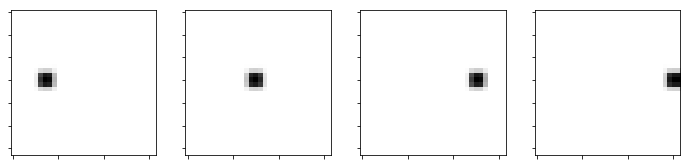

In [3]:
data_path = "data/moving-box/processed/single-uniform-32x32.npz"
data = np.load(data_path)
imgs, info = data['imgs'], data['info']
print("imgs shape:     {}".format(imgs.shape))
print("info:           {}".format(info))
num_train = imgs.shape[0]
sample_and_show_many(imgs, 4)

### Proprocess: [0, 1] -> [-1, 1]

In [4]:
def preprocess(imgs):
    return 2*imgs-1

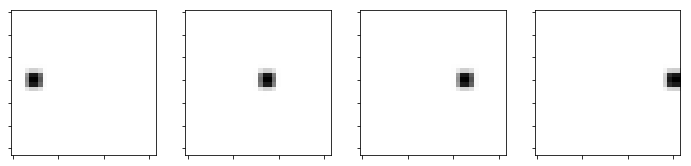

In [5]:
imgs = preprocess(imgs)
sample_and_show_many(imgs, 4)

#### Sample Data from Training Corpus

In [6]:
gap = 3
batch_size = 8
def sample_real():
    """
    return: (before, after), mid
    """
    before_indexes = np.random.choice(range(len(imgs) - gap - 1), batch_size, replace=False)
    before_indexes.sort()
    after_indexes = before_indexes + gap + 1
    mid_indexes = (before_indexes + after_indexes)//2
    return (imgs[before_indexes], imgs[after_indexes]), imgs[mid_indexes]

#### test sample_real

Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


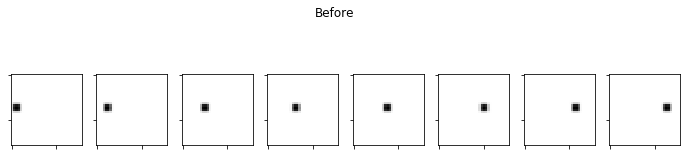

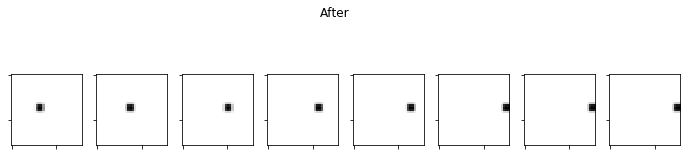

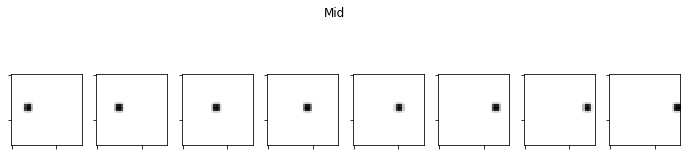

In [7]:
(test_before, test_after), test_mid = sample_real()
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (12, 3)
plot_images(test_before, size, "Before")
plot_images(test_after, size, "After")
plot_images(test_mid, size, "Mid")

#### test stack

In [8]:
stacked = stack_imgs([test_before, test_after])
print("Stacked: {}".format(stacked.shape))

Stacked: (8, 32, 32, 2)


## GAN

In [9]:
def leaky_relu(x, alpha=0.01):
    return tf.maximum(alpha * x, x)

### Params

In [10]:
learning_rate = 8e-4
beta = 0.5
num_epoch = 400
noise_dim = 128
relu_alpha = 0.01

### Loss

In [11]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)


def gan_loss(logits_real, logits_fake):
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits = logits_fake)
    
    D_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits = logits_real)\
     +  tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits = logits_fake)
        
    G_loss = tf.reduce_mean(G_loss)
    D_loss = tf.reduce_mean(D_loss)
    return D_loss, G_loss

## Discriminator

In [12]:
def discriminate(x):
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, [-1,  32, 32, 1])
        x = tf.layers.conv2d(x, filters=32, kernel_size=5)
        x = leaky_relu(x, relu_alpha)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")
        
        x = tf.layers.conv2d(x, 64, kernel_size=5)
        x = leaky_relu(x, relu_alpha)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 4*4*64)
        x = leaky_relu(x, relu_alpha)
        logits = tf.layers.dense(x, 1)
        return logits

## Generator

In [13]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator"):
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([(x1+x2)/2, (x2-x1)/2], axis=3)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        
        img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(img, [-1, 32, 32, 1])
        return img

### Solver

In [14]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

### Run a GAN !

In [15]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

with tf.variable_scope("") as scope:
    logits_real = discriminate(batch_mid)
    scope.reuse_variables()
    logits_fake = discriminate(G_batch)

D_loss, G_loss = gan_loss(logits_real, logits_fake)
G_loss += content_loss(G_batch, batch_mid)
D_solver, G_solver = get_solvers(learning_rate, beta)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [16]:
def train(sess, G_step, D_step, G_loss, D_loss, batch_size, num_eposh, plot_every = 80, show_loss_every=80):
    max_iter = int(num_train*num_epoch/batch_size)
    d_losses, g_losses = [], []
    for i in range(max_iter):
        (real_before, real_after), real_mid = sample_real()
        
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, D_loss_curr = sess.run([D_train_step, D_loss], dic)
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        if i%show_loss_every ==0:
            print("Iteration {}: D_loss = {} | G_loss = {}".format(i, D_loss_curr, G_loss_curr))
            d_losses.append(D_loss_curr)
            g_losses.append(G_loss_curr)
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict={batch_before: test_before, batch_after: test_after, is_training: False})
            plot_batch_images(gen_batch_test, (16, 2) , "Iteration: {}".format(i))
    return d_losses, g_losses

Iteration 0: D_loss = 1.3734287023544312 | G_loss = 102.84786987304688


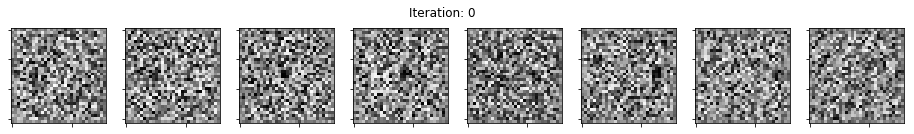

Iteration 80: D_loss = 0.22526267170906067 | G_loss = 32.47055435180664


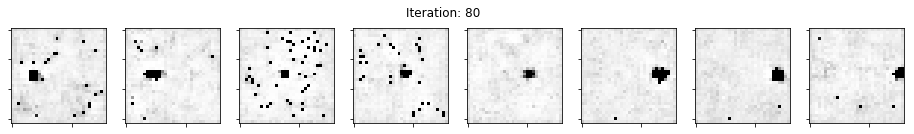

Iteration 160: D_loss = 0.5646380186080933 | G_loss = 21.862865447998047


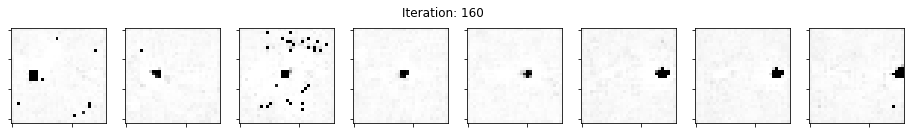

Iteration 240: D_loss = 0.47327518463134766 | G_loss = 10.20614242553711


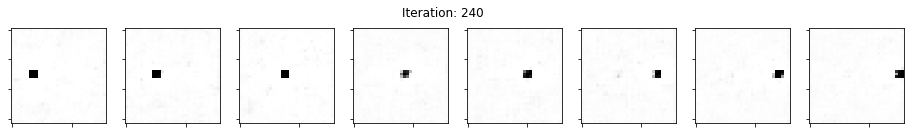

Iteration 320: D_loss = 0.2678621709346771 | G_loss = 11.908138275146484


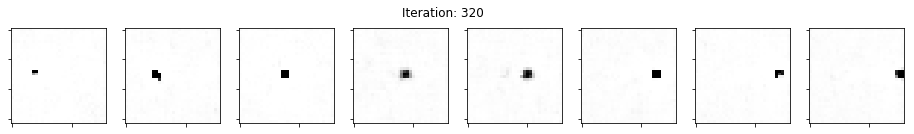

Iteration 400: D_loss = 0.6507093906402588 | G_loss = 6.79480504989624


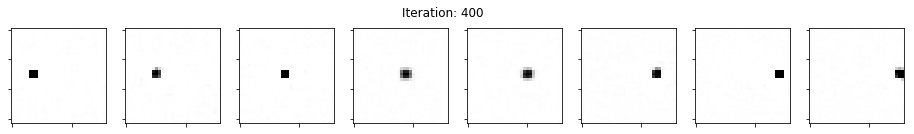

Iteration 480: D_loss = 1.0929903984069824 | G_loss = 5.659448623657227


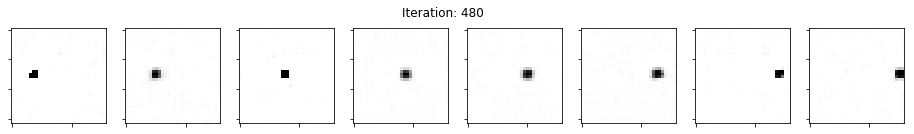

Iteration 560: D_loss = 0.9288673996925354 | G_loss = 6.634897708892822


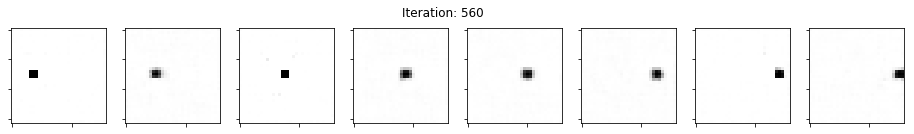

Iteration 640: D_loss = 0.3543385863304138 | G_loss = 11.431069374084473


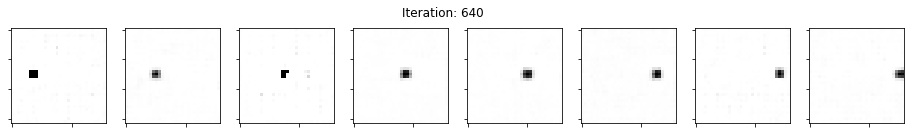

In [17]:
sess = get_session()
sess.run(tf.global_variables_initializer())
d_loss, g_loss = train(sess, G_train_step, D_train_step, G_loss, D_loss, batch_size, num_epoch)

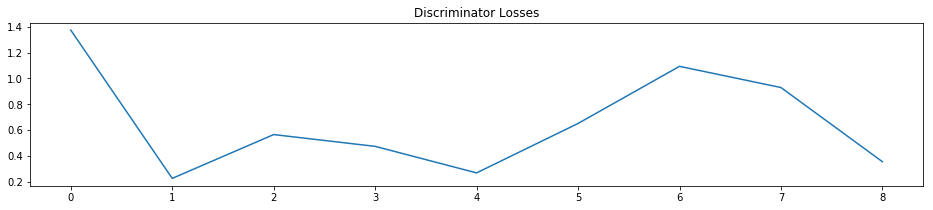

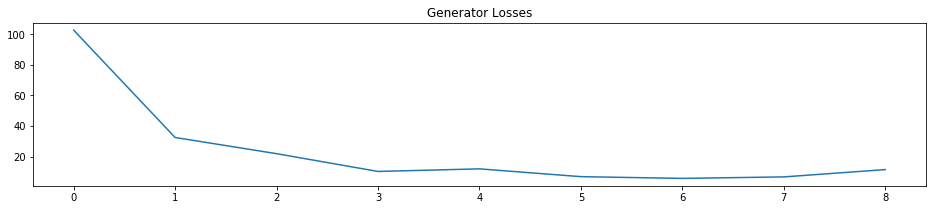

In [18]:
figsize = (16, 3)
plt.figure(figsize=figsize)
plt.plot(d_loss)
plt.title("Discriminator Losses")
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

#### test

In [19]:
def test():
    """
    randomely sample and test generator
    """
    (real_before, real_after), real_mid = sample_real()
    dic = {batch_before: real_before, batch_after: real_after, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    size = (12, 2)
    plot_images(test_before, size, "Before")
    plot_images(test_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

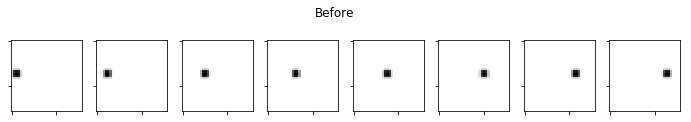

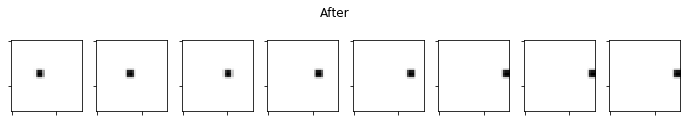

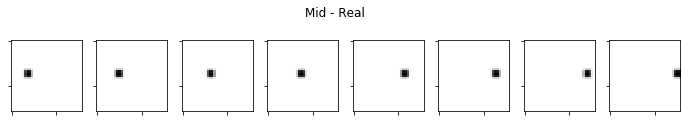

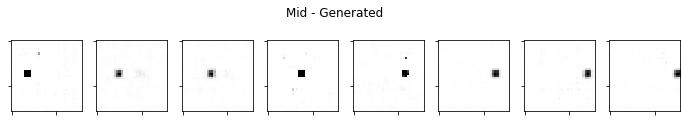

In [20]:
test()

## Without Discriminater

What is the role of Discriminator here in frame prediction? What if just generator?

In [21]:
learning_rate = 8e-4
beta = 0.5
num_epoch = 400
noise_dim = 128
relu_alpha = 0.01

In [22]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

with tf.variable_scope("") as scope:
    logits_real = discriminate(batch_mid)
    scope.reuse_variables()
    logits_fake = discriminate(G_batch)

G_loss = content_loss(G_batch, batch_mid)
_, G_solver = get_solvers(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [23]:
def train(sess, G_step, G_loss, batch_size, num_eposh, plot_every = 200, show_loss_every=200):
    max_iter = int(num_train*num_epoch/batch_size)
    g_losses = []
    for i in range(max_iter):
        (real_before, real_after), real_mid = sample_real()
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            g_losses.append(G_loss_curr)
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict={batch_before: test_before, batch_after: test_after, is_training: False})
            plot_batch_images(gen_batch_test, (16, 2) , "Iteration: {}".format(i))
    return g_losses

Iteration 0:  G_loss = 100.7898178100586


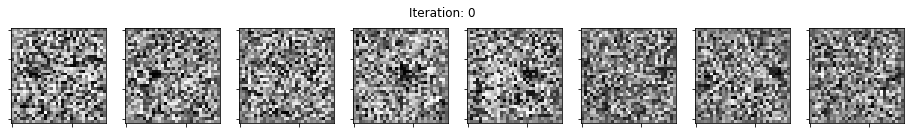

Iteration 80:  G_loss = 34.717594146728516


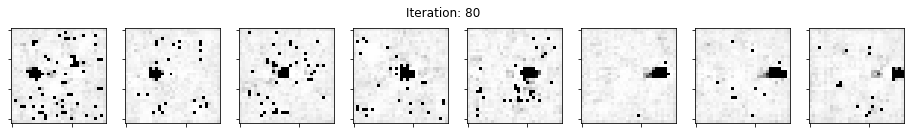

Iteration 160:  G_loss = 28.126779556274414


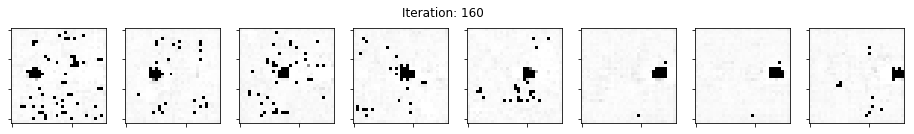

Iteration 240:  G_loss = 21.500280380249023


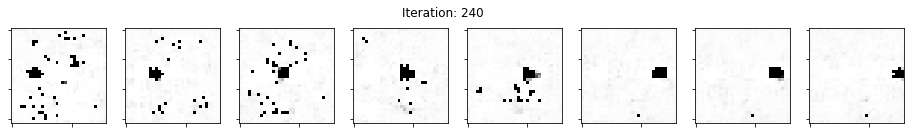

Iteration 320:  G_loss = 9.97144889831543


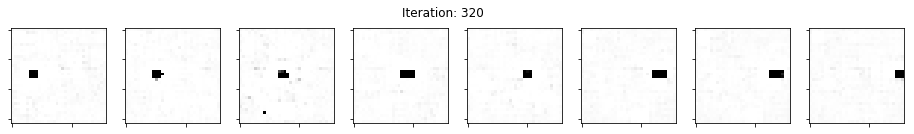

Iteration 400:  G_loss = 5.506216049194336


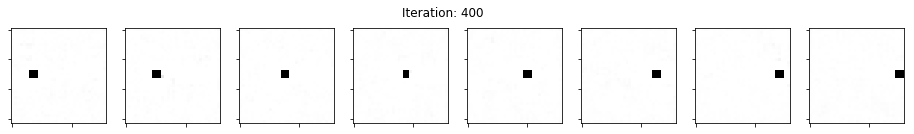

Iteration 480:  G_loss = 4.926635265350342


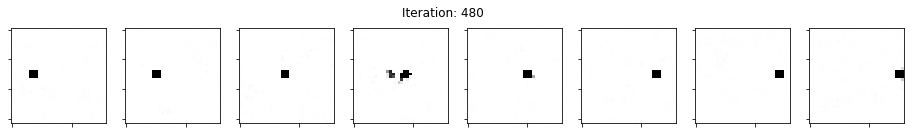

Iteration 560:  G_loss = 4.891828536987305


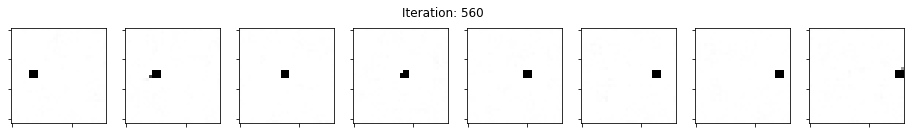

Iteration 640:  G_loss = 5.43544340133667


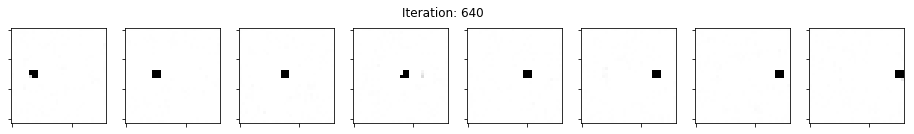

In [24]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_epoch)

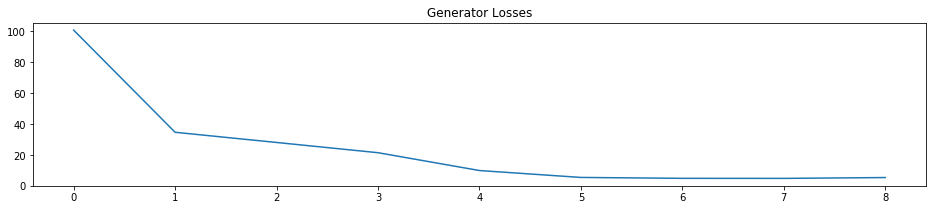

In [25]:
figsize = (16, 3)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

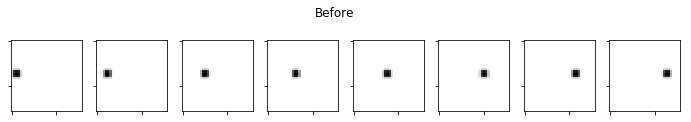

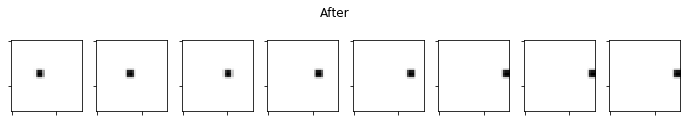

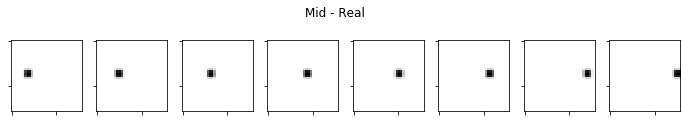

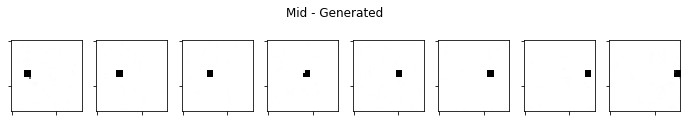

In [26]:
test()

OK So it seems that the discriminator basically is useless in this case